(quickstart-df)=

# Quickstart: Data Frames

This quickstart provides a quick walkthrough of the `Meerkat` data frame, which allows users to interact with unstructured data alongside standard tabular data.

In [1]:
import os
import meerkat as mk
import numpy as np

## 💾 Downloading the data
First, we'll download some data to explore. We're going to use the [Imagenette dataset](https://github.com/fastai/imagenette#image%E7%BD%91), a small subset of the original [ImageNet](https://www.image-net.org/update-mar-11-2021.php).  This dataset is made up of 10 classes (e.g. "garbage truck", "gas pump", "golf ball").
- Download time: < 1 minute
- Download size: 130M

In addition to downloading the data, `download_imagnette` prepares a CSV, `imagenette.csv`, with a row for each image.

In [2]:
from meerkat.datasets.imagenette import download_imagenette

dataset_dir = "./downloads"
os.makedirs(dataset_dir, exist_ok=True)
download_imagenette(dataset_dir, overwrite=True)

Downloading:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

Extracting tar archive, this may take a few minutes...


Let's take a look at the CSV.

In [3]:
!head -n 5 downloads/imagenette2-160/imagenette.csv

label,split,img_path
cassette player,train,train/n02979186/n02979186_9036.JPEG
cassette player,train,train/n02979186/n02979186_11957.JPEG
cassette player,train,train/n02979186/n02979186_9715.JPEG
cassette player,train,train/n02979186/n02979186_21736.JPEG


Next, we'll load it into a Meerkat `DataFrame`.

## 📸 Creating an image `DataFrame`
*For more information on creating DataFrames from various data sources, see the user guide section on {ref}`guide/dataframe/io`.*

Meerkat's core contribution is the DataFrame, a simple columnar data abstraction. The Meerkat DataFrame can house columns of arbitrary type – from integers and strings to complex, high-dimensional objects like videos, images, medical volumes and graphs.

We're going to build a `DataFrame` out of the `imagenette.csv` file from the download above.


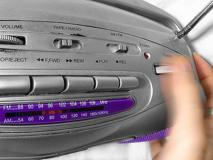
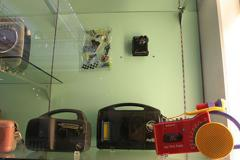
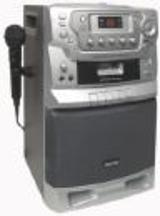
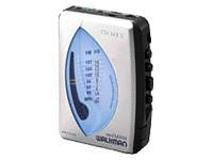
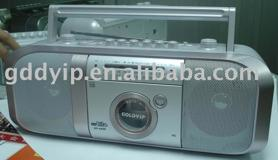
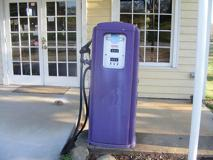
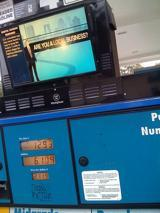
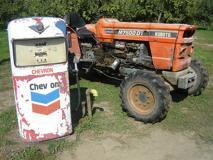
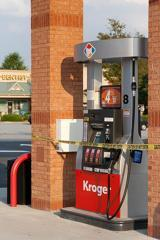
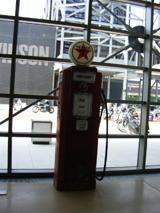

In [4]:
# Create a `DataFrame`
df = mk.from_csv("./downloads/imagenette2-160/imagenette.csv")

# Create an `ImageColumn`` and add it to the `DataFrame`
df["img"] = mk.image(
    df["img_path"], 
    base_dir=os.path.join(dataset_dir, "imagenette2-160")
)
df

The call to `head` shows the first few rows in the `DataFrame`. You can see that there are a few metadata columns, as well as the "img" column we added in.

## 🗂 Selecting data
*For more information see the user guide section on {ref}`guide/dataframe/selection`.*

When we create an `ImageColumn` we don't load the images into memory. Instead, `ImageColumn` keeps track of all those filepaths we passed in and only loads the images when they are needed. 

When we select a row of the `ImageColumn`, we get an instance `FileCell` back. A `FileCell` is an object that holds everything we need to materialize the cell (e.g. the filepath to the image and the loading function), but stops just short of doing so.

In [5]:
img_cell = df["img"][0]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img_cell)}.")

Indexing the `ImageColumn` returns an object of type: <class 'meerkat.columns.deferred.file.FileCell'>.


To actually materialize the image, we simply call the cell.

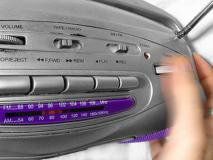

In [6]:
img = img_cell()
img

We can subselect a **batch** of images by indexing with a slice.  Notice that this returns a smaller {class}`~meerkat.DataFrame`.

Indexing a slice of the `ImageColumn` returns a: <class 'meerkat.columns.deferred.file.FileColumn'>.


column([FileCell(fn=<...7f9ca8184b50>), FileCell(fn=<...7f9ca8184b50>), FileCell(fn=<...7f9ca8184b50>)], backend=FileColumn
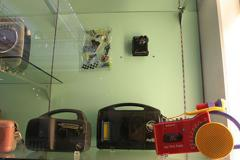
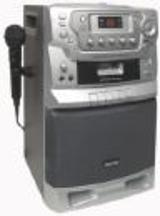
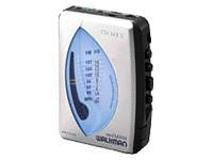

In [7]:
imgs = df["img"][1:4]
print(f"Indexing a slice of the `ImageColumn` returns a: {type(imgs)}.")
imgs

The whole batch of images can be loaded together by calling the column. 
```
imgs();
```

One can load multiple rows using any one of following indexing schemes:
- **Slice indexing**: _e.g._ `column[4:10]`
- **Integer array indexing**: _e.g._ `column[[0, 4, 6, 11]]`
- **Boolean array indexing**: _e.g._ `column[np.array([True, False, False ..., True, False])]`

### 📎 _Aside_: `ImageColumn` under the hood, `DeferredColumn`.

If you check out the implementation of `ImageColumn` (at [meerkat/column/image_column.py](https://github.com/HazyResearch/meerkat/blob/main/meerkat/column/image_column.py)), you'll notice that it's a super simple subclass of `DeferredColumn`. 

_What's a `DeferredColumn`?_
In `meerkat`, high-dimensional data types like images and videos are typically stored in a `DeferredColumn`. A  `DeferredColumn` wraps around another column and lazily applies a function to it's content as it is indexed. Consider the following example, where we create a simple `meerkat` column...

In [8]:
  col = mk.column([0,1,2])

...and wrap it in a deferred column.
```
  dcol = col.defer(fn=lambda x: x + 10)
  dcol[1]()  # the function is only called at this point!
```
Critically, the function inside a lambda column is only called at the time the column is called! This is very useful for columns with large data types that we don't want to load all into memory at once. For example, we could create a `DeferredColumn` that lazily loads images...
```
  >>> filepath_col = mk.PandasSeriesColumn(["path/to/image0.jpg", ...])
  >>> img_col = filepath.defer(lambda x: load_image(x))
```
An `ImageColumn` is a just a `DeferredColumn` like this one, with a few more bells and whistles!

## 🛠 Applying operations over the DataFrame.

When analyzing data, we often perform operations on each example in our dataset (e.g. compute a model's prediction on each example, tokenize each sentence, compute a model's embedding for each example) and store them. The `DataFrame` makes it easy to perform these operations:  
- Produce new columns (via `DataFrame.map`)
- Produce new columns and store the columns alongside the original data (via `DataFrame.update`)
- Extract an important subset of the datset (via `DataFrame.filter`).   

Under the hood, dataloading is multiprocessed so that costly I/O doesn't bottleneck our computation.

Let's start by filtering the `DataFrame` down to the examples in the validation set.

In [9]:
valid_df = df[df["split"] == "valid"]

### 🫐  Using `DataFrame.map` to compute average intensity of the blue color channel in the images.

To demonstrate the utility of the `map` operation, we'll explore the relationship between the "blueness" of an image and the class of the image. 

We'll quantify the "blueness" of each image by simply computing the mean intensity of the blue color channel. This can be accomplished with a simple `map` operation over the `DataFrame`:

In [10]:
blue_col = valid_df.map(
    lambda img: np.array(img)[:, :, 2].mean(), 
    num_workers=2
)

# Add the intensities as a new column in the `DataFrame` 
valid_df["avg_blue"] = blue_col

### 🪂 vs. ⛳️
Next, we'll explore the relationship between blueness and the class label of the image. To do so, we'll compare the blue intensity distribution of images labeled "parachute" to the distribution of of images labeled "golf ball".
Using the [`seaborn`](https://seaborn.pydata.org/installing.html) plotting package and our `DataFrame`, this can be accomplished in one line:

/home/runner/work/meerkat/meerkat/meerkat/dataframe.py:901: UserWarning: Could not convert column img of type <class 'meerkat.columns.deferred.file.FileColumn'>, it will be dropped from the output.
  warnings.warn(


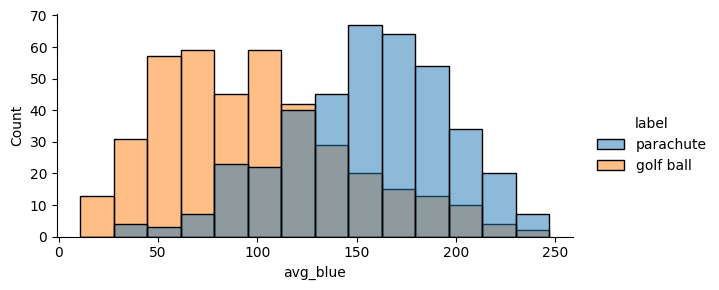

In [11]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns

plot_df = valid_df[np.isin(valid_df["label"], ["golf ball", "parachute"])]
sns.displot(
    data=plot_df.to_pandas(), 
    x="avg_blue", 
    hue="label", 
    height=3, 
    aspect=2
)

In [12]:
valid_df["img"][int(np.argmax(valid_df["avg_blue"]))]

FileCell(fn=<meerkat.columns.deferred.file.FileLoader object at 0x7f9ca8184b50>)

## 💾  Writing a `DataFrame` to disk. 
Finally, we can write the updated `DataFrame` to disk for later use.

In [13]:
valid_df.write(os.path.join(dataset_dir, "valid_df"))

In [14]:
valid_df = mk.read(os.path.join(dataset_dir, "valid_df"))